In [21]:
!pip install colorama
!pip install transformers

<h1><b><span style="color: #e56b6f; font-size: 28px">Libraries & Packages</span></b></h1>


In [40]:
import numpy as np
import pandas as pd
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt

from colorama import Fore

import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder

from transformers import RobertaTokenizer, AdamWeightDecay, TFAutoModel, TFRobertaModel

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import (Input, LSTM, BatchNormalization,
                                        Dense, Dropout, Activation)
from tensorflow.keras import Model
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import plot_model

nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

<h1><b><span style="color: #e56b6f; font-size: 28px">Defaults and Helper Function</span></b></h1>


In [37]:
#defaults
SEQ_LEN = 80
EPOCHS = 10
BATCH_SIZE = 32

class CleanTweet():
    '''
    Remove non-english characters and newline char
    Remove numbers, hyperlink, mentions and hashtags
    '''
    def __init__(self, pattern):
        self.pattern = pattern

    def __call__(self, text):
        if isinstance(text, str):
            tweet = text

        tweet = re.sub(self.pattern, '', tweet)

        return tweet

clean = CleanTweet(r'(\n+)|([0-9])|(#?\s?[^\u0000-\u05C0\u2100-\u214F]+)|'
                   r'(#[A-Za-z0-9]+)|(https?:\/\/.*[\r\n]*)|(@[A-Za-z0-9]+)')

def cleanLemmatize(text):
    #remove punctuations and uppercase
    clean_text = text.translate(str.maketrans('','',string.punctuation)).lower()

    #remove stopwords
    clean_text = [word for word in clean_text.split() if word not in stopwords.words('english')]

    #lemmatize the word
    sentence = []
    for word in clean_text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word, 'v'))

    return ' '.join(sentence)


def dfInfo(df, name):
    negative = df[df.sentiment == 0].shape[0]
    neutral = df[df.sentiment == 1].shape[0]
    positive = df[df.sentiment == 2].shape[0]

    print(f"\n{name} -----> shape : {df.shape}")
    print(f"{name} -----> negative: {negative}, neutral: {neutral}, positive: {positive}\n")

    return None


def tokenize(df, tokenizer:RobertaTokenizer):
    input_ids =  []
    att_masks =  []

    for i, text in enumerate(df['text']):
        tokens = tokenizer.encode_plus(text, max_length=SEQ_LEN,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_attention_mask=True,
                                   return_token_type_ids=False, return_tensors='tf')

        input_ids.append(np.asarray(tokens['input_ids']).reshape(SEQ_LEN,))
        att_masks.append(np.asarray(tokens['attention_mask']).reshape(SEQ_LEN,))

    return (np.asarray(input_ids), np.asarray(att_masks))


class RoBERTa():

    def __init__(self, train_id, test_id,
                 train_mask, test_mask,
                 train_y, test_y,
                 epochs, batch_size):
        self.train_id = train_id
        self.test_id = test_id
        self.train_mask = train_mask
        self.test_mask = test_mask
        self.train_y = train_y
        self.test_y = test_y
        self.epoch = epochs
        self.size = batch_size

    def train(self):
        input_ids = Input(shape=(SEQ_LEN,), name='input_ids', dtype='int32')
        mask = Input(shape=(SEQ_LEN,), name='attention_mask', dtype='int32')

        roberta = TFAutoModel.from_pretrained("roberta-base")
        embeddings = roberta(input_ids, attention_mask=mask)[0]

        x = LSTM(128)(embeddings)
        x = BatchNormalization()(x)
        x = Dense(768)(x)
        x = Activation('relu')(x)
        x = Dense(768)(x)
        x = Dropout(0.1)(x)
        y = Dense(3, activation='softmax', name='outputs')(x)

        model = Model(inputs=[input_ids, mask], outputs=y)
        model.layers[2].trainable = False

        print(model.summary())

        self.model = model

        model.compile(
            optimizer=AdamWeightDecay(1e-3, beta_1=.8,
                                      beta_2=.9, weight_decay_rate=1e-03),
            loss=CategoricalCrossentropy(),
            metrics=[CategoricalAccuracy('accuracy')]
        )

        history = model.fit(
            (self.train_id, self.train_mask), self.train_y.toarray(),
            validation_data=((self.test_id, self.test_mask), self.test_y.toarray()),
            epochs=self.epoch,
            batch_size=self.size,
            callbacks= [EarlyStopping(patience=5, verbose=1),
                        ModelCheckpoint('models/roberta.tf',
                                          verbose=1,
                                          save_best_only=True
                                          )
                                    ]
        )

        return history, model

    def model_arc(self):
        return plot_model(
                  self.model, to_file='model_arc.png', show_shapes=True, show_dtype=True,
                  show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96,
                  layer_range=None
              )


<h1><b><span style="color: #e56b6f; font-size: 28px">Data Loading & Preparation</span></b></h1>


In [24]:
new_df = pd.read_csv('processed_data.csv')
new_df.head()

,text,sentiment
0,come ask leave house sunday live eviction show...,2
1,gonna lie big brother mess isnt fair even fan,2
2,production team doesnt care bite people mental...,0
3,kayode one responsible show bore hms,2
4,video s fan protest bbnaijas eviction twist lagos,1


In [25]:
train, test = train_test_split(new_df, test_size = 0.2, shuffle=True)

dfInfo(train, 'train')
dfInfo(test, 'validation')

train_x, train_y = train[['text']], train[['sentiment']]

test_x, test_y = test[['text']], test[['sentiment']]


train -----> shape : (15284, 2)
train -----> negative: 2214, neutral: 6981, positive: 6089


validation -----> shape : (3822, 2)
validation -----> negative: 545, neutral: 1769, positive: 1508



In [26]:
train_y = OneHotEncoder().fit_transform(np.array(train_y).reshape(-1, 1))
test_y = OneHotEncoder().fit_transform(np.array(test_y).reshape(-1, 1))


In [27]:
test_y.toarray()

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

<h1><b><span style="color: #e56b6f; font-size: 20px">Tokenization</span></b></h1>


In [28]:
#Tokenization with RoBERTa Tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [29]:
train_ids, train_masks = tokenize(train_x, tokenizer=tokenizer)
valid_ids, valid_masks = tokenize(test_x, tokenizer=tokenizer)

In [30]:
train_ids[0]

array([    0,   417,  2533, 21943,  2968,    29, 33976, 21662,  1369,
        2350, 10219,   900, 11907,  2968,    29,     2,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1],
      dtype=int32)

<h1><b><span style="color: #e56b6f; font-size: 28px">Model Training</span></b></h1>


In [31]:
model = RoBERTa(train_ids, valid_ids,
                train_masks, valid_masks, train_y,
                test_y, epochs=10, batch_size=32)
history, model = model.train()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 80)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 80)]                 0         []                            
 )                                                                                                
                                                                                                  
 tf_roberta_model_2 (TFRobe  TFBaseModelOutputWithPooli   1246456   ['input_ids[0][0]',           
 rtaModel)                   ngAndCrossAttentions(last_   32         'attention_mask[0][0]']      
                             hidden_state=(None, 80, 76                                     

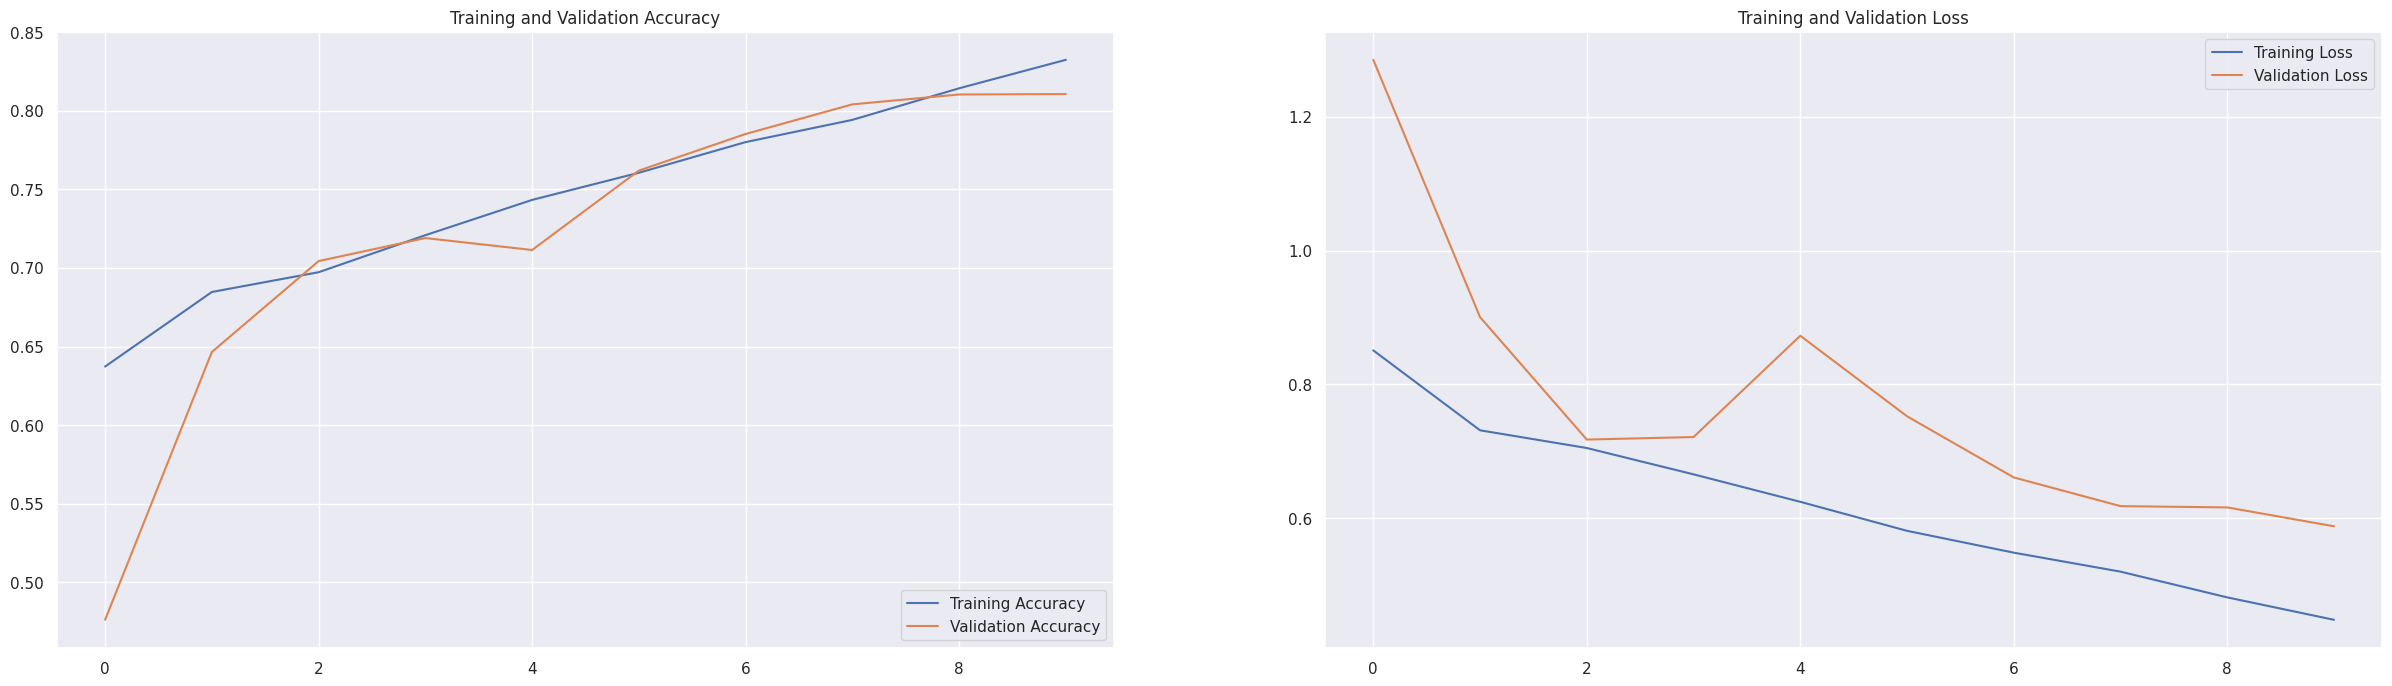

In [33]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(30, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

<h1><b><span style="color: #e56b6f; font-size: 28px">Inference and Results</span></b></h1>


In [34]:
def prep_data(text):
    text = clean(text)

    tokens = tokenizer.encode_plus(text, max_length=80,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_token_type_ids=False,
                                   return_tensors='tf')

    return {'input_ids': tf.cast(tokens['input_ids'], tf.float64),
            'attention_mask': tf.cast(tokens['attention_mask'], tf.float64)}

def predict(text):
    in_tensor = prep_data(text)
    probs = model.predict(in_tensor)[0]
    return (np.argmax(probs))

In [35]:
#predict on the first 40 tweets in the validation dataset

predictions = np.asarray(test['text'][:40].apply(lambda x: predict(x)))
test_vals = test_y[:40].toarray().argmax(1)


1/1 [==============================] - 0s 105ms/step


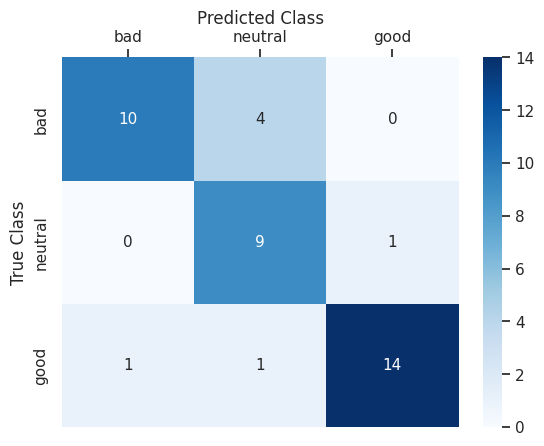

              precision    recall  f1-score   support

         bad     0.9091    0.7143    0.8000        14
     neutral     0.6429    0.9000    0.7500        10
        good     0.9333    0.8750    0.9032        16

    accuracy                         0.8250        40
   macro avg     0.8284    0.8298    0.8177        40
weighted avg     0.8522    0.8250    0.8288        40



In [36]:
confusion = confusion_matrix(test_vals, predictions)

# plot confusion matrix
sns.set(font_scale=1.0)
labels = ["bad", "neutral", "good"]
ax = sns.heatmap(confusion, annot=True, annot_kws={"size": 11},
                 fmt='d', vmin = 0, cmap='Blues', yticklabels=labels,
                 xticklabels=labels)
ax.set_xlabel('Predicted Class')
ax.set_ylabel('True Class')
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
plt.show()

# print classification report
report = classification_report(test_vals, predictions, digits = 4, output_dict=False,
                               target_names=["bad", "neutral", "good"],)
print(report)

<h1><b><span style="color: #e56b6f; font-size: 28px">Deployment</span></b></h1>


In [42]:
def dl_predict(text):
    clean_text = cleanLemmatize(text)
    in_tensor = prep_data(clean_text)
    probs = model.predict(in_tensor)[0]
    pred = (np.argmax(probs))

    if pred == 0:
        sentiment = Fore.RED +'Negative'

    elif pred == 1:
        sentiment = Fore.BLACK + 'Neutral'

    else:
        sentiment = Fore.GREEN + 'Positive'

    print(text + ' is a ' + sentiment + ' tweet ')

text = '"Angel is a very bad person. She shouldnt have done that to Pere"'

dl_predict(text)

1/1 [==============================] - 0s 92ms/step
"Angel is a very bad person. She shouldnt have done that to Pere" is a Negative tweet 


In [46]:
text2 = '"wtf is wrong with queen!!"'

dl_predict(text2)

1/1 [==============================] - 0s 178ms/step
"wtf is wrong with queen!!" is a Negative tweet 


In [49]:
text3 = '"Big brother is being fair in the decision:)"'

dl_predict(text3)

1/1 [==============================] - 0s 86ms/step
"Big brother is being fair in the decision:)" is a Positive tweet 
